Установка необходимых библиотек:

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/"

/content/drive/MyDrive


В качестве датасетов использованы данные по поездкам yellow taxi за декабрь 2019 и январь 2020 с официального сайта г. Нью-Йорк:

https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [ ]:
df_jan = pd.read_csv('/content/drive/MyDrive/yellow_tripdata_2020-01.csv')
df_dec = pd.read_csv('/content/drive/MyDrive/yellow_tripdata_2019-12.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df_jan.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1.0,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5
1,1.0,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1.0,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5
2,1.0,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1.0,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5
3,1.0,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1.0,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0
4,2.0,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2.0,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0


In [ ]:
df_dec.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2019-12-01 00:26:58,2019-12-01 00:41:45,1.0,4.2,1.0,N,142,116,2.0,14.5,3.0,0.5,0.0,0.0,0.3,18.3,2.5
1,1.0,2019-12-01 00:12:08,2019-12-01 00:12:14,1.0,0.0,1.0,N,145,145,2.0,2.5,0.5,0.5,0.0,0.0,0.3,3.8,0.0
2,1.0,2019-12-01 00:25:53,2019-12-01 00:26:04,1.0,0.0,1.0,N,145,145,2.0,2.5,0.5,0.5,0.0,0.0,0.3,3.8,0.0
3,1.0,2019-12-01 00:12:03,2019-12-01 00:33:19,2.0,9.4,1.0,N,138,25,1.0,28.5,0.5,0.5,10.0,0.0,0.3,39.8,0.0
4,1.0,2019-12-01 00:05:27,2019-12-01 00:16:32,2.0,1.6,1.0,N,161,237,2.0,9.0,3.0,0.5,0.0,0.0,0.3,12.8,2.5


In [ ]:
df_unclear = df_dec.append(df_jan, ignore_index=True)
df = df_unclear.copy()

In [ ]:
df_jan, df_dec = [], []

#***Разведочный анализ***#


In [ ]:
df.dtypes

VendorID                 float64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type             float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
dtype: object

In [ ]:
df.isna().sum()

VendorID                 116459
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          116459
trip_distance                 0
RatecodeID               116459
store_and_fwd_flag       116459
PULocationID                  0
DOLocationID                  0
payment_type             116459
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge          0
dtype: int64

Пропущенные значения составляют лишь малую часть данных от общего числа, поэтому вместо замены на среднее/медиану/моду просто дропну их.

In [ ]:
df.dropna(inplace=True)

In [ ]:
df = df.astype({'VendorID': 'int', 'RatecodeID': 'int', 'payment_type' : 'int'})

In [ ]:
df[["tpep_pickup_datetime", "tpep_dropoff_datetime"]] = df[["tpep_pickup_datetime", "tpep_dropoff_datetime"]].astype('datetime64[ns]')

Посмотрим описательную статистику:

In [ ]:
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,1.318487e+07,1.318487e+07,1.318487e+07,1.318487e+07,1.318487e+07,1.318487e+07,1.318487e+07,1.318487e+07,1.318487e+07,1.318487e+07,1.318487e+07,1.318487e+07,1.318487e+07,1.318487e+07,1.318487e+07
mean,1.667980e+00,1.533787e+00,2.899569e+00,1.062944e+00,1.644183e+02,1.623319e+02,1.285196e+00,1.298932e+01,1.096852e+00,4.936646e-01,2.236968e+00,3.572071e-01,2.979711e-01,1.900764e+01,2.295475e+00
std,4.709382e-01,1.163589e+00,6.510600e+00,8.757305e-01,6.568355e+01,7.002877e+01,4.815006e-01,1.104274e+02,1.252851e+00,6.866321e-02,2.824207e+00,1.721354e+00,3.396974e-02,1.107658e+02,7.070883e-01
min,1.000000e+00,0.000000e+00,-2.301000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.472000e+03,-2.700000e+01,-5.000000e-01,-2.008000e+02,-4.050000e+01,-3.000000e-01,-1.472800e+03,-2.500000e+00
25%,1.000000e+00,1.000000e+00,9.500000e-01,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.127000e+01,2.500000e+00
50%,2.000000e+00,1.000000e+00,1.600000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.500000e+00,5.000000e-01,5.000000e-01,1.950000e+00,0.000000e+00,3.000000e-01,1.475000e+01,2.500000e+00
75%,2.000000e+00,2.000000e+00,2.940000e+00,1.000000e+00,2.340000e+02,2.340000e+02,2.000000e+00,1.450000e+01,2.500000e+00,5.000000e-01,2.960000e+00,0.000000e+00,3.000000e-01,2.030000e+01,2.500000e+00
max,2.000000e+00,9.000000e+00,1.913018e+04,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,3.984684e+05,1.130100e+02,3.080000e+01,1.100000e+03,9.105000e+02,3.000000e-01,3.984712e+05,3.000000e+00




В датафрейме присутствуют аномальные отрицательные значения.
Избавлюсь от них.


In [ ]:
df = df.query('trip_distance > 0 & fare_amount	> 0 & extra > 0 &	mta_tax > 0')



#***1. Исследование корреляции стоимости поездки с другими факторами.***#



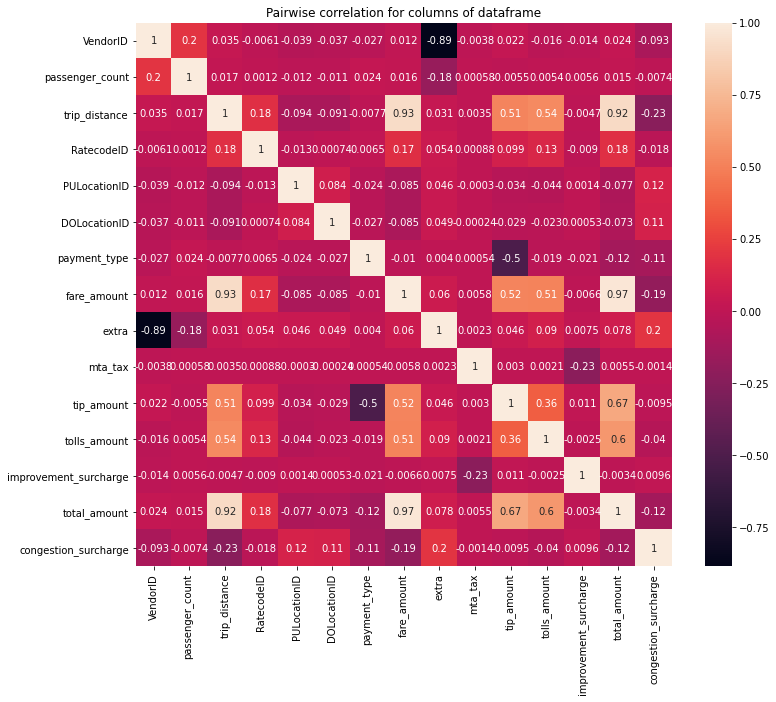

In [ ]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(12,10))
ax.set_title('Pairwise correlation for columns of dataframe')
ax = sns.heatmap(corr, ax=ax, annot=True)

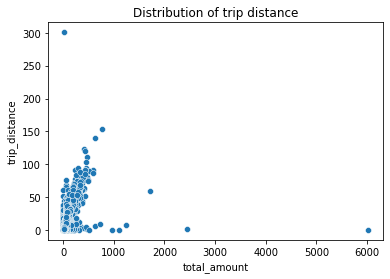

In [ ]:
sns.scatterplot(data=df, x="total_amount", y="trip_distance")
plt.title('Distribution of trip distance')
plt.show()

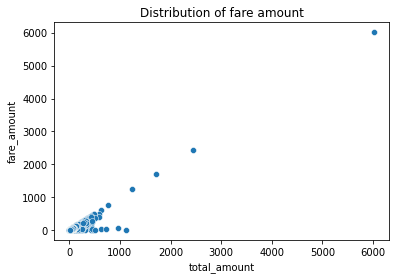

In [ ]:
sns.scatterplot(data=df, x="total_amount", y="fare_amount")
plt.title('Distribution of fare amount')
plt.show()

Стоимость поездки (total_amount) имеет сильную положительную корреляцию с дистанцией поездки (trip_distance) и со стоимостью проезда по счетчику (fare_amount), а также слабую корреляцию с суммой чаевых по карте (tip_amount) и с суммой всех сборов (tolls_amount).

Объяснить это просто - чем больше дистанция поездки, тем она дороже, а стоимость проезда по счетчику вносит наибольший вклад в сумму чека.

#***2. Поиск аномальных поездок.***#

Во первых, это поездки, значения дистанции поездки, стоимости поездки по счетчику, а также чаевых по карте и сумме всех соборов которых отрицательны.

In [ ]:
df_anomaly = df.query('trip_distance < 0 & fare_amount < 0 & extra < 0 & mta_tax < 0')

Построим новую фичу на основе данных о времени посадки и высадки пассажиров:

In [ ]:
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).astype('timedelta64[m]')

In [ ]:
df[df['trip_duration'] < 0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_duration
2036290,1,2019-12-09 15:53:10,2019-12-05 15:33:42,1.0,3.7,1,N,186,13,1,19.5,2.5,0.5,3.00,0.0,0.3,25.80,2.5,-5780.0
7436357,1,2020-01-04 08:19:55,2020-01-02 10:09:33,1.0,3.5,1,N,107,237,1,16.5,2.5,0.5,4.95,0.0,0.3,24.75,2.5,-2771.0


Получили несколько записей, в которых длительность поездки отрицательна, что явно выглядит как аномалии.

In [ ]:
df_anomaly = df_anomaly.append(df[df['trip_duration'] < 0], ignore_index=True)

In [ ]:
df = df[df['trip_duration'] >= 0]

Проверим, нет ли поездок, совершенных в даты отличные от декабря 2019 и января 2020.

In [ ]:
len(df[df['tpep_pickup_datetime'] >= '2020-02-01'].index)

58

In [ ]:
len(df[df['tpep_pickup_datetime'] <= '2019-11-30'].index)

55

Действительно, такие поездки присутствуют, что является аномалией.

In [ ]:
df_anomaly = df_anomaly.append(df[df['tpep_pickup_datetime'] <= '2019-11-30'], ignore_index=True)
df_anomaly = df_anomaly.append(df[df['tpep_pickup_datetime'] >= '2020-02-01'], ignore_index=True)

In [ ]:
df = df[df['tpep_pickup_datetime'] < '2020-02-01']
df = df[df['tpep_pickup_datetime'] > '2019-11-30']

Изучим выбросы с помощью boxplot:

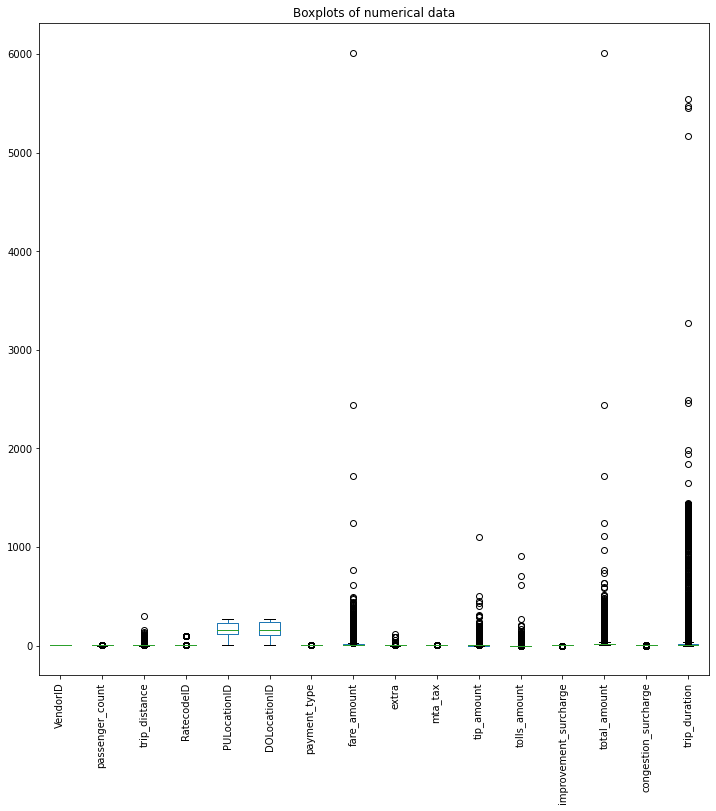

In [ ]:
boxplot = df.boxplot(grid=False, rot=90, figsize=(12, 12))
plt.title('Boxplots of numerical data')
plt.show()

Так как в датафрейсе присутствуют данные, соответсвующие разным тарифам, стоит поискать выбросы не во всем датафрейме сразу, а внутри каждого тарифа.

In [ ]:
df['RatecodeID'].unique()

array([ 1,  2,  4,  5, 99,  3])

В столбце RatecodeID присутстсвует редко встречающаяся значение (99), которого нет в документации к данным.

In [ ]:
df_anomaly = df_anomaly.append(df[df['RatecodeID'] == 99], ignore_index=True)

Для определения выбросов воспользуемся IQR. Будем рассматривать только сильные выбросы, имеющие крайние отклонения. Для большинства случаев будем рассматривать только верхние пределы, так как нижние (в виду особенностей услуг автоперевозок) не представляют особого интереса.

In [ ]:
ratecode =  [1, 2, 3, 4, 5]

list1 = ['passenger_count',	'trip_distance',	'fare_amount',	'extra',	'mta_tax',	'tip_amount',	
         'tolls_amount', 'trip_duration',	'improvement_surcharge', 'total_amount',	'congestion_surcharge']


for x in ratecode:
  for i in list1:
    df_rate = df[df['RatecodeID'] == x]
    q25, q75 = df_rate[i].quantile(.25), df_rate[i].quantile(.75)
    iqr = q75 - q25
    cut = iqr * 3
    up = q75 + cut
    df_anomaly = df_anomaly.append(df_rate[df_rate[i] > up], ignore_index=True)

In [ ]:
df_anomaly.drop_duplicates(inplace=True)
df_anomaly

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_duration
0,1,2019-12-09 15:53:10,2019-12-05 15:33:42,1.0,3.70,1,N,186,13,1,19.50,2.5,0.5,3.00,0.0,0.3,25.80,2.5,-5780.0
1,1,2020-01-04 08:19:55,2020-01-02 10:09:33,1.0,3.50,1,N,107,237,1,16.50,2.5,0.5,4.95,0.0,0.3,24.75,2.5,-2771.0
2,2,2008-12-31 23:03:32,2008-12-31 23:18:00,5.0,1.64,1,N,144,249,2,8.50,0.5,0.5,0.00,0.0,0.3,12.30,2.5,14.0
3,2,2009-01-01 00:00:35,2009-01-01 00:29:02,3.0,14.46,1,N,132,129,2,40.00,0.5,0.5,0.00,0.0,0.3,41.30,0.0,28.0
4,2,2008-12-31 23:55:51,2009-01-01 00:27:49,1.0,9.65,1,N,138,16,2,32.50,1.0,0.5,0.00,0.0,0.3,34.30,0.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212783,2,2019-12-13 08:39:10,2019-12-14 07:43:11,1.0,0.12,5,N,164,264,2,45.00,2.5,0.5,0.00,0.0,0.3,48.30,0.0,1384.0
1212784,2,2019-12-16 00:00:00,2019-12-16 23:42:49,2.0,0.67,5,N,229,264,2,76.50,2.5,0.5,0.00,0.0,0.3,79.80,0.0,1422.0
1212785,2,2019-12-17 20:40:51,2019-12-18 19:43:07,1.0,34.50,5,N,164,264,2,150.00,2.5,0.5,0.00,10.5,0.3,163.80,0.0,1382.0
1212786,2,2020-01-09 17:00:54,2020-01-09 20:23:23,1.0,1.35,5,N,125,132,2,32.79,0.8,0.5,0.00,0.0,0.0,34.09,0.0,202.0


Датафрейм с аномальными записями получен. Очистим основной датафрейм от аномалий:

In [ ]:
df_clear = pd.concat([df, df_anomaly, df_anomaly]).drop_duplicates(keep=False)
df_clear

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_duration
0,1,2019-12-01 00:26:58,2019-12-01 00:41:45,1.0,4.20,1,N,142,116,2,14.5,3.0,0.5,0.00,0.0,0.3,18.30,2.5,14.0
4,1,2019-12-01 00:05:27,2019-12-01 00:16:32,2.0,1.60,1,N,161,237,2,9.0,3.0,0.5,0.00,0.0,0.3,12.80,2.5,11.0
5,1,2019-12-01 00:58:51,2019-12-01 01:08:37,2.0,1.00,1,N,161,230,2,6.5,3.0,0.5,0.00,0.0,0.3,10.30,2.5,9.0
6,1,2019-12-01 00:14:19,2019-12-01 00:27:06,0.0,1.70,1,Y,164,163,2,10.0,3.0,0.5,0.00,0.0,0.3,13.80,2.5,12.0
7,1,2019-12-01 00:29:35,2019-12-01 00:32:29,0.0,0.50,1,N,79,224,1,4.0,3.0,0.5,1.55,0.0,0.3,9.35,2.5,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13235878,2,2020-01-31 23:00:01,2020-01-31 23:21:31,1.0,4.11,1,N,48,75,1,17.5,0.5,0.5,4.26,0.0,0.3,25.56,2.5,21.0
13235879,2,2020-01-31 23:38:07,2020-01-31 23:52:21,1.0,2.10,1,N,163,246,1,11.0,0.5,0.5,2.96,0.0,0.3,17.76,2.5,14.0
13235880,2,2020-01-31 23:00:18,2020-01-31 23:19:18,1.0,2.13,1,N,164,79,1,13.0,0.5,0.5,3.36,0.0,0.3,20.16,2.5,19.0
13235881,2,2020-01-31 23:24:22,2020-01-31 23:40:39,1.0,2.55,1,N,79,68,1,12.5,0.5,0.5,3.26,0.0,0.3,19.56,2.5,16.0


#***3. Построение распределения стоимости поездок и проверка гипотезы о его нормальности.***#

Посторим распредление и график квантиль-квантиль:

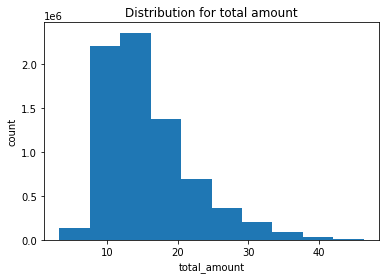

In [ ]:
ax = df_clear['total_amount'].plot(kind='hist', title='Distribution for total amount')
ax.set(xlabel='total_amount', ylabel='count')
plt.show()

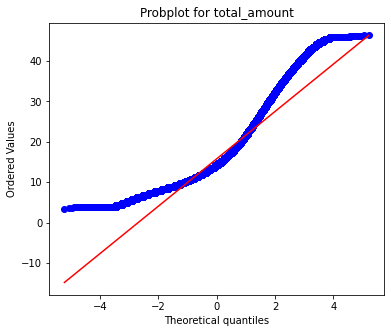

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
res = scipy.stats.probplot(x=df_clear['total_amount'], plot=ax)
ax.set_title("Probplot for total_amount")
plt.show()

Графики явно указывают на отклоение распредления от нормального.

Для достоверности проверки проведем статистический тест. Рассмотрим две гипотезы: нулевая гипотеза – данные распределены нормально, альтернативная гипотеза – данные не имеют нормального распределения.

Проведем тест по критерию Шапиро-Уилк, возвращающий значение вычисленной статистики и p-значение. В качестве критического значения возьмем стандартные 0.05. При p-значении меньше 0.05 мы вынуждены отклонить нулевую гипотезу.

In [ ]:
stat, p = scipy.stats.shapiro(df_clear['total_amount']) # тест Шапиро-Уилк

print('Statistics=%.3f, p-value=%.5f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=0.911, p-value=0.00000
Отклонить гипотезу о нормальности


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Тест показал значение p-value < 0.05, следовательно гипотеза о нормальности отклоняется. 

Для размеров выборки такого порядка данные тесты, возможно, довольно бесполезны, поскольку даже незначительные отклонения от нормальности будут считаться значительными на обычных уровнях. 

#***4.  Описание тарифа (т.е. стоимости поездки от других факторов).***#

Посмотрим, как количество совершенных поездок распределено по времени суток:

Создадим несколько новых фичей:

- стоимость поездки за километр
- стоиимость поездки за минуту

Для расчета использую показания со счетчика (fare_amount), так как сумма налогов фиксированная парктически во всех случаях, а также есть поездки без итоговой оплаты.

In [ ]:
df_clear['price_per_minute'] = df_clear['fare_amount'] / df_clear['trip_duration']

In [ ]:
df_clear['price_per_mile'] = df_clear['fare_amount'] / df_clear['trip_distance']

In [ ]:
df_clear.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_duration,price_per_minute,price_per_mile
0,1,2019-12-01 00:26:58,2019-12-01 00:41:45,1.0,4.2,1,N,142,116,2,14.5,3.0,0.5,0.00,0.0,0.3,18.30,2.5,14.0,1.035714,3.452381
4,1,2019-12-01 00:05:27,2019-12-01 00:16:32,2.0,1.6,1,N,161,237,2,9.0,3.0,0.5,0.00,0.0,0.3,12.80,2.5,11.0,0.818182,5.625000
5,1,2019-12-01 00:58:51,2019-12-01 01:08:37,2.0,1.0,1,N,161,230,2,6.5,3.0,0.5,0.00,0.0,0.3,10.30,2.5,9.0,0.722222,6.500000
6,1,2019-12-01 00:14:19,2019-12-01 00:27:06,0.0,1.7,1,Y,164,163,2,10.0,3.0,0.5,0.00,0.0,0.3,13.80,2.5,12.0,0.833333,5.882353
7,1,2019-12-01 00:29:35,2019-12-01 00:32:29,0.0,0.5,1,N,79,224,1,4.0,3.0,0.5,1.55,0.0,0.3,9.35,2.5,2.0,2.000000,8.000000


Опишем стандартный тариф медианными значениями:

In [ ]:
print('Цена такси за минуту %.2f$' % df_clear['price_per_minute'].median(),
      '\nЦена такси за милю %.2f$' % df_clear['price_per_mile'].median())

Цена такси за минуту 0.94$ 
Цена такси за милю 5.56$


Посмотрим распределение цен в зависимости от времени суток:

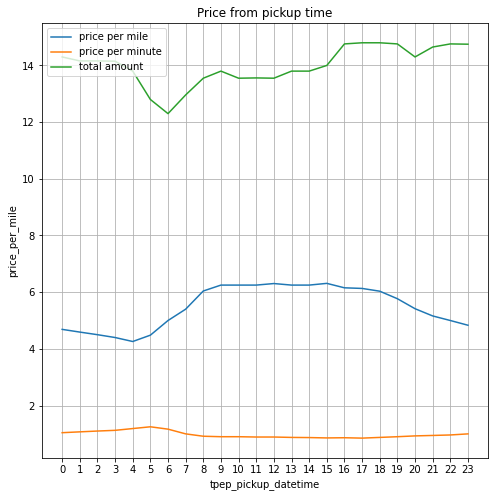

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(data=df_clear.groupby(df_clear['tpep_pickup_datetime'].dt.hour).agg({'price_per_mile' : 'median'}).reset_index(),
             x="tpep_pickup_datetime", y='price_per_mile')
sns.lineplot(data=df_clear.groupby(df_clear['tpep_pickup_datetime'].dt.hour).agg({'price_per_minute' : 'median'}).reset_index(),
             x="tpep_pickup_datetime", y='price_per_minute')
sns.lineplot(data=df_clear.groupby(df_clear['tpep_pickup_datetime'].dt.hour).agg({'total_amount' : 'median'}).reset_index(),
             x="tpep_pickup_datetime", y='total_amount')

plt.legend(['price per mile', 'price per minute', 'total amount'], loc='upper left')
plt.title('Price from pickup time')
plt.xticks(df_clear['tpep_pickup_datetime'].dt.hour.unique())
plt.grid()
#plt.xticks(standart_rate["tpep_pickup_datetime"], rotation=90)
plt.show()

Распределение цен в зависимости от количества пассажиров:

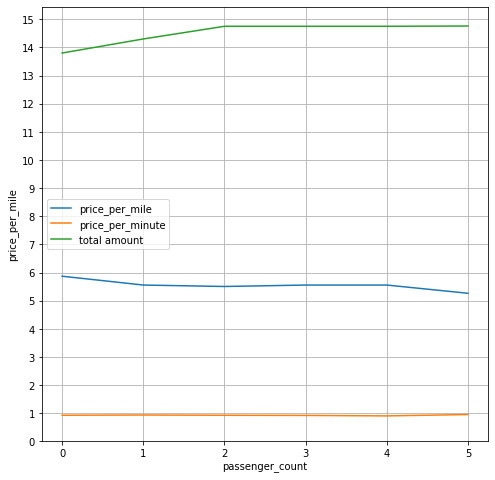

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(data=df_clear.groupby(df_clear['passenger_count']).agg({'price_per_mile' : 'median'}).reset_index(),
             x="passenger_count", y='price_per_mile')
sns.lineplot(data=df_clear.groupby(df_clear['passenger_count']).agg({'price_per_minute' : 'median'}).reset_index(),
             x="passenger_count", y='price_per_minute')
sns.lineplot(data=df_clear.groupby(df_clear['passenger_count']).agg({'total_amount' : 'median'}).reset_index(),
             x="passenger_count", y='total_amount')
plt.legend(['price_per_mile', 'price_per_minute', 'total amount'], loc='center left')
plt.grid()
plt.yticks(np.arange(0, 16, 1))
#plt.xticks(standart_rate["tpep_pickup_datetime"], rotation=90)
plt.show()

Посмотрим распределение цен в зависимости от тарифа:

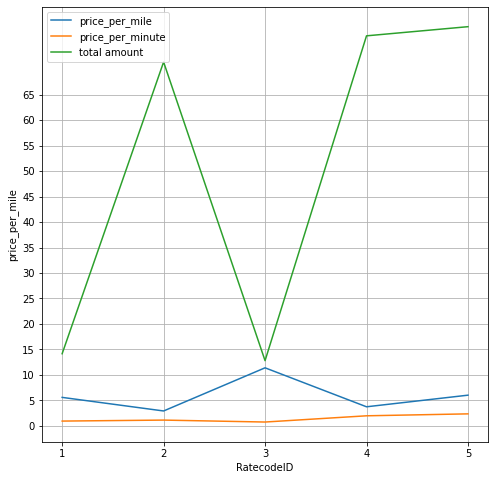

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(data=df_clear.groupby(df_clear['RatecodeID']).agg({'price_per_mile' : 'median'}).reset_index(),
             x="RatecodeID", y='price_per_mile')
sns.lineplot(data=df_clear.groupby(df_clear['RatecodeID']).agg({'price_per_minute' : 'median'}).reset_index(),
             x="RatecodeID", y='price_per_minute')
sns.lineplot(data=df_clear.groupby(df_clear['RatecodeID']).agg({'total_amount' : 'median'}).reset_index(),
             x="RatecodeID", y='total_amount')
plt.grid()
plt.legend(['price_per_mile', 'price_per_minute', 'total amount'], loc='upper left')
plt.xticks(df_clear['RatecodeID'].unique())
plt.yticks(np.arange(0, 70, 5))
plt.show()

Стоимость поездки явно зависит от времени суток, начиная повышаться с 6 утра и до 23 с пиком в промежутке с 16 до 19 (в момент когда большинство людей возвращаются с работы).
Также на стоимость поездки влияет количество пассажиров - одному пассажиру ехать дешевле, чем с попутчиками. Но при этом цена не изменяется при количестве пассажиров >= 2.
Сильное влияние на стоимость поездки оказывает тариф. 

#***5. Определение дней, в которых проводились скидки или акции.***#

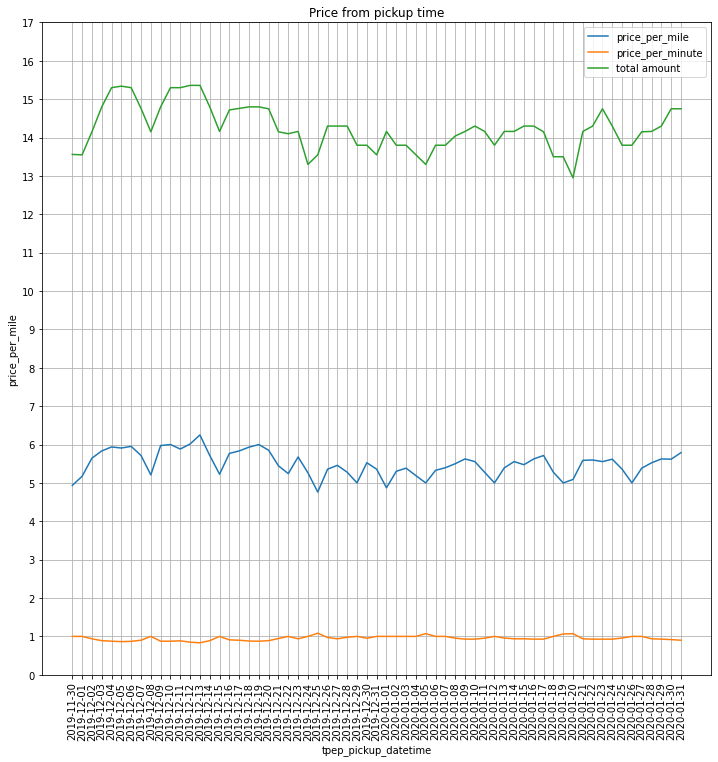

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
sns.lineplot(data=df_clear.groupby(df_clear['tpep_pickup_datetime'].dt.date).agg({'price_per_mile' : 'median'}).reset_index(),
             x="tpep_pickup_datetime", y='price_per_mile')
sns.lineplot(data=df_clear.groupby(df_clear['tpep_pickup_datetime'].dt.date).agg({'price_per_minute' : 'median'}).reset_index(),
             x="tpep_pickup_datetime", y='price_per_minute')
sns.lineplot(data=df_clear.groupby(df_clear['tpep_pickup_datetime'].dt.date).agg({'total_amount' : 'median'}).reset_index(),
             x="tpep_pickup_datetime", y='total_amount')

plt.legend(['price_per_mile', 'price_per_minute', 'total amount'], loc='upper right')
plt.title('Price from pickup time')
plt.xticks(df_clear['tpep_pickup_datetime'].dt.date.unique(), rotation=90)
plt.yticks(np.arange(0, 18, 1))
plt.grid()
#plt.xticks(standart_rate["tpep_pickup_datetime"], rotation=90)
plt.show()

Если судить по распределению медианных цен за весь период, то можно заметить паднение в периоды с 24 по 25 декабря, 31 декабря, c 19 на 20 января. Объяснить это можно появлением скидок и акций в период празднований Рождества, Нового года и Дня Мартина Лютера Кинга.